In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import itertools

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.simplefilter('ignore')

C:\Users\ataga\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [3]:
Path_Energy = 'my_PJME_MW (2).csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
data_w = data.resample('W').mean()
data_w.tail()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,3.000000,11.500000,0.142857,0.142857,0.142857
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-29,36581.821429,2018.0,7.000000,26.000000,3.0,207.000000,30.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-08-05,36568.804124,2018.0,7.505155,15.865979,3.0,212.525773,31.0,1.525773,11.381443,0.000000,0.000000,0.000000


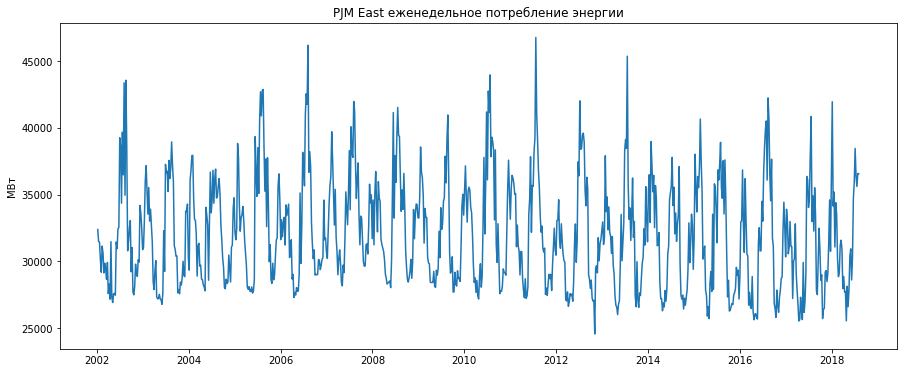

In [5]:
plt.figure(figsize =(15, 6))
plt.plot( data_w.index, data_w['PJME_MW'].values)
plt.title('PJM East еженедельное потребление энергии')
plt.ylabel ('МВт');

#### Сначала найдем оптимальные параметры ARIMA

In [ ]:
p = range(2, 10)
d = range(2, 10)
q = range(2, 10)

# зададим сетку p, d и q
pdq = list(itertools.product(p, d, q))

for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-30],
                                order=param,
                                seasonal_order=[1, 1, 2, 26],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
        aic_ = 1000000
        param_ = None 
        param_seasonal_ = None
        results = mod.fit()
        if results.aic < aic_:
            aic_ = results.aic
            param_ = param 
            param_seasonal_ = param_seasonal
    except:
        continue
print('SARIMAX {} x {} - AIC: {}'.format(param_, param_seasonal_, aic_))

Добавим скользящее среднее по всей модели с глубиной 4 недели

In [ ]:
data_w['w_m'] = data_w['PJME_MW'].rolling(window=4).mean()

In [ ]:
Добавим сглаживание

In [ ]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_5'] = exponential_smoothing(data_w['PJME_MW'], 0.5)

Добавим истории длиной p в признаках автокорреляции

In [ ]:
p = 7
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности

In [ ]:
p = 7
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [ ]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [ ]:
train, test = split_data(data_w, '01-06-2016')

plt.figure(figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

## Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты моделирования ARIMA.

In [ ]:
h = 4

In [ ]:
X_train_4 = train.iloc[:-h,:]

In [ ]:
y_train_4 = train[df.columns[0]].values[:-h]

In [ ]:
X_test_4 = test.iloc[:-h,:]

In [ ]:
y_test_4 = test[df.columns[0]].values[:-h]

In [ ]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

model_gb.fit(X_train_4, y_train_4) 
X_test_pred_gb_4 = model_gb.predict(X_test_4)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
plt.figure( figsize=(16, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h: h + 50], X_test_pred_gb_4[: 50], label='Предсказание')
plt.plot(test.index[h: h + 50], y_test_4[: 50], label='test data')
plt.legend()
plt.show()

er_g_4 = mean_absolute_percentage_error(y_true=y_test_4, y_pred=X_test_pred_gb_4)

print('ошибка градиентного бустинга :  ', er_g_4, '%')

## Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты моделирования ARIMA.

In [ ]:
h = 1

In [ ]:
X_train_1 = train.iloc[:-h,:]

In [ ]:
y_train_1 = train[df.columns[0]].values[:-h]

In [ ]:
X_test_1 = test.iloc[:-h,:]

In [ ]:
y_test_1 = test[df.columns[0]].values[:-h]

In [ ]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

model_gb.fit(X_train_1, y_train_1) 
X_test_pred_gb_1 = model_gb.predict(X_test_1)

In [ ]:
plt.figure( figsize=(16, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h: h + 50], X_test_pred_gb_1[: 50], label='Предсказание')
plt.plot(test.index[h: h + 50], y_test_4[: 50], label='test data')
plt.legend()
plt.show()

er_g_1 = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb_1)

print('ошибка градиентного бустинга :  ', er_g_1, '%')

## Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки bp 4-х точек.

In [ ]:
#['PJME_MW', 'dayofweek', 'd_w7', 'exp_0_05', 't1', 't6']
X_test_rec = X_test.copy()
y_test_rec = y_test_pred_g.copy()
N = 4
for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]

In [ ]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1: N+1], y_test_pred_g_4[:N], 'r', label='Предсказание путем прямого моделирования' )
plt.plot(test.index[1: N+1], y_test[:N], 'g', label='test data', alpha=0.5)
plt.plot(test.index[1: N+1], y_test_rec[:N], '--r', label='Предсказание путем рекурсивного моделирования')

plt.legend()
plt.show()    

In [ ]:
er_g_rec = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])

print('ошибка градиентного бустинга:  ', er_g_4, '%')
print('ошибка рекурсивного моделирования:  ', er_g_rec, '%')

## Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

In [ ]:
N = 10

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_10 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_10, '%')

In [ ]:
N = 20

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_20 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_20, '%')

In [ ]:
N = 30

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_30 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_30, '%')

In [ ]:
N = 40

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_40 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_40, '%')

In [ ]:
N = 50

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_50 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_50, '%')

In [ ]:
N = 60

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_60 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_60, '%')

In [ ]:
N = 70

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_70 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_70, '%')

In [ ]:
N = 80

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_80 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_80, '%')

In [ ]:
N = 90

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_90 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_90, '%')

In [ ]:
N = 100

for i in range(N):
    y_test_rec[i] = model_g_best.predict(X_test_rec[i, :].reshape((1, 6)))
    X_test_rec[i+1, 0] = y_test_rec[i]
    X_test_rec[i+1, 4] = X_test_rec[i, 0]
    if i>4:
        X_test_rec[i+1, 5] = X_test_rec[i-5, 0]
er_g_rec_100 = mean_absolute_percentage_error(y_true=y_test[:N], y_pred=y_test_rec[:N])
print('ошибка рекурсивного моделирования:  ', er_g_rec_100, '%')

## Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.